In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

# Clustering with *Gaussian Mixture Models*

Clustering is one of the most popular applications of *unsupervised learning*. The goal of clustering algorithms is to group data into sets of observations with similar behavior. There are numerous real-world applications across various fields: for example, customer segmentation, where we group "similar" users; search engines, where we cluster similar results; and image compression, where pixels that correspond to the same objects are grouped together. A common trait among these applications is the absence of labeled data, unlike in supervised learning. If we already had labels indicating the group of each point, we wouldn’t need to perform any clustering algorithm, except when predicting labels for new data. In unsupervised learning, however, the primary challenge is discovering unknown patterns in the data.

The most well-known clustering technique is **K-Means**. In brief, it works by initially assigning points to K clusters based on randomly selected cluster centers, and then refining these clusters iteratively by recomputing the centers as the mean of the cluster points. However, this notebook will focus not on K-Means (you can refer to the `kmeans` notebook for that) but on another powerful approach: **Gaussian Mixture Models (GMMs).**

## Mixture of Gaussians: a theoretical introduction
One main drawback of K-Means is that it inherently groups points within hyperspheres, with the cluster radius defined by the furthest point from the cluster centroid. This approach is effective if the data exhibits spherical symmetry, but it may perform poorly otherwise. Another limitation is that K-Means is a **deterministic** algorithm that performs hard classification: each data point is assigned to exactly one cluster, without any probabilistic measure of that assignment.

Gaussian Mixture Models address both these limitations, although at the cost of a more complex algorithm. GMMs fall under the category of *density estimation* algorithms. The basic idea is to learn the probability density of data points and use that density for labeling unknown data. Since data can have complex structures, instead of learning a "simple" probability distribution like a single Gaussian or Beta distribution, GMMs use a probabilistic model where the underlying distribution is a linear combination of multiple basic distributions. This approach is effective for clustering because if our data is organized into $K$ clusters, we can model the overall distribution as a linear combination of $K$ basic distributions, which may not necessarily be spherical.

In general, Gaussian distributions are chosen as the building blocks because they work well in many applications. This approach addresses both drawbacks of K-Means clustering:
 - By combining (Gaussian) distributions with different means and variances, GMMs can model clusters with various shapes (elliptical in case of Gaussians), not limited to spherical symmetry;
- Learning a probability distribution allows for *soft* classification, where we know the probability that a point belongs to a given cluster.

Let now discuss how the model works. We consider a linear combinations of $K$ Gaussian densities of the form
$$
p(\boldsymbol{x}) = \sum_{k=1}^K \pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$
which is called a *mixture of Gaussians*. Each Gaussian density is called a *component* of the mixture and it has its own mean $\boldsymbol{\mu}_k$ and covariance matrix $\boldsymbol{\Sigma}_k$. The parameters $\pi_k$ are called **mixing coefficients**. If we integrate both sides of the above equation:
$$
\int p(\boldsymbol{x}) d\boldsymbol{x} = 1 = \sum_{k=1}^K \pi_k \int \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) d\boldsymbol{x}
$$
Since Gaussian distributions are normalized, we get
$$
\sum_{k=1}^K \pi_k = 1
$$
Also, given that $\mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \geq 0$, a sufficient condition for $p(\boldsymbol{x}) \geq 0$ is that the mixing coefficients be not vanishing for any $k$. Combining these finds, we get $$0 \leq \pi_k \leq 1$$ which means that $\pi_k$ can be theirselved considered as probabilities. From the sum and product rules of probabilities, we can then write the marginal density $p(\boldsymbol{x})$ as:
$$
p(\boldsymbol{x}) = \sum_{k=1}^K p(k) p(\boldsymbol{x} | k )
$$
In this context, we can view $\pi_k = p(k)$ as the **prior probability** of picking the $k$-th component of the Gaussian mixture and the Gaussian density $p(\boldsymbol{x} |k)$ as the probability of $\boldsymbol{x}$ conditioned on the $k$ component. If one is familiar with *Bayesian statistics*, he may be interested in the form of the so-called **posterior probability**, $p(k|\boldsymbol{x})$, which is basically the probability of $k$-th component *once* we have actually observed the data. According to the Bayes's theorem we can write:
$$
\begin{align}
\gamma_k(\boldsymbol{x}) \equiv p(k|\boldsymbol{x}) = \frac{p(k) p(\boldsymbol{x}| k)}{\sum_j p(j)p(\boldsymbol{x}|j)} = \frac{\pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_j \pi_j \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
\end{align}
$$
The quantities $\gamma_k$ are known as **responsibilities**. They play a very important role in the theory of GMMs since they naturally emerge in the so-called maximum likelihood approach. Indeed, once we have defined the form of the mixture, we then need to learn the parameters governing the distribution. In this case, it means that we need to the set the values of $(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})$. In the maximum-likelihood framework, this translates into maximizing the log of the likelihood function given by
$$
\ln p(\boldsymbol{X}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N \ln \left(\sum_{k=1}^K \pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right)
$$
where $\boldsymbol{X}$ is the set of data points $\{ \boldsymbol{x}_1, ..., \boldsymbol{x}_N\}$. The reader can easily prove that computing the derivative of the above function leads to an expression where responsibilities appear naturally.

The summation over $k$ inside the logarithm makes the optimization procedure far more complex than in K-means or in single density estimations. As a result, the maximum likelihood solution no longer has a closed-form analytical solution. Therefore, to maximize the likelihood function we need to use another approach. One strategy is to use iterative numerical optimization algorithms. However, in this notebook we will use another approach, the so-called **expectation-maximization** algorithm.

### Expectation-Maximization (EM)

In K-Means, the cost function being optimized is the sum of the squared distances between each data point and its assigned cluster center. In *naive* K-Means, this optimization happens in two stages: first, the cluster centers are fixed, and the cost function is optimized with respect to the cluster assignments, typically by assigning each data point to the nearest cluster center. In the second stage, the assignments are kept fixed, and the cost function is optimized with respect to the cluster centers by setting them to the mean of the data points belonging to each cluster, based on the results of the first step. These two stages are commonly known as the **Expectation (E)** and **Maximization (M)** steps of the **EM algorithm**. The EM algorithm can be applied in various contexts, including Gaussian Mixture Models (GMMs),
In particular, for GMMs, it works as follows:

1. We randomly initialize $\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}$ to some initial values;
2. <span style="color: blue">**Expectation**</span>: We evaluate the *responsibilities* using the current parameter values:

<div style="text-align: center; border: 2px solid blue; background-color: #E0F7FF; padding: 10px; display: inline-block;">
\[
\gamma_{nk} = \frac{\pi_k \mathcal{N} (\boldsymbol{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_j \pi_j \mathcal{N} (\boldsymbol{x}_n|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
\]
</div>

3. <span style="color: blue">**Maximization**</span>: We re-estimate the parameters using the current responsibilities:

<div style="text-align: center; border: 2px solid blue; background-color: #E0F7FF; padding: 10px; display: inline-block;">
\[
\begin{gather} 
\boldsymbol{\mu}_k^{new} = \frac{1}{N_k} \sum_n^N \gamma_{nk}\boldsymbol{x}_n \\
\boldsymbol{\Sigma}_k^{new} = \frac{1}{N_k} \sum_n^N  \sum_n^N \gamma_{nk}(\boldsymbol{x}_n-\boldsymbol{\mu}_k^{new})(\boldsymbol{x}_n - \boldsymbol{\mu}_k^{new})^T \\
\pi_k^{new} = \frac{N_k}{N}
\end{gather}
\]
</div> $$N_k = \sum_n^N \gamma_{nk}$$

4. We evaluate the log likelihood and check for convergence.

Here, we won't delve into the theoretical justification of this procedure or the EM algorithm in general, as a thorough explanation would first require an understanding of the so-called *latent variables*. For those interested, references at the end of the notebook provide further reading on the topic.

Instead, we'll focus on how to use the native implementation of GMM in `scikit-learn` for clustering purposes, using a toy dataset as an example. In addition, we’ll also provide a simple implementation from scratch of the EM procedure. 

## GMMs with `sklearn`

To illustrate how to apply GMMs with scikit-learn, let consider a rather simple dataset, namely the famous *Old Faithful data set, which comprises 272 measurements of the eruption of the **Old Faithful geyser** at **Yellowstone National Park** in Wyoming, USA. 

![Old-Faithful](../images/old-faithful-geyser.jpg)

In [7]:
df = pd.read_csv("../datasets/old-faithful.csv", sep=",")

In [9]:
print(f"Number of measurements: {len(df)}")
print(f"Columns: {list(df.columns)}")

Number of measurements: 272
Columns: ['id', 'eruptions', 'waiting']


The dataset consists of 272 measurements of the duration of the eruption in minutes (`eruption`) and the time in minutes to the next eruption (`waiting`).

<Axes: xlabel='eruptions', ylabel='waiting'>

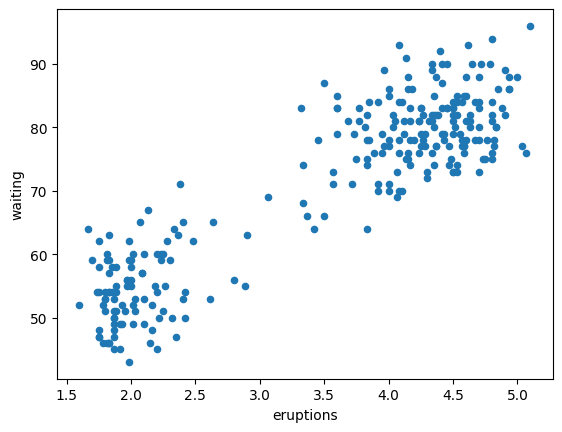

In [11]:
df.plot(x="eruptions", y="waiting", kind="scatter")

In [13]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)

In [15]:
X = df[["eruptions", "waiting"]].values

In [18]:
X.shape

(272, 2)

In [19]:
gmm.fit(X)

GaussianMixture(n_components=2, random_state=42)

In [20]:
# Step 4: Predict the cluster for each data point
labels = gmm.predict(X)

In [24]:
# Step 5: Plot the contour lines for each Gaussian
x = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
y = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)

In [25]:
Xx, Yy = np.meshgrid(x, y)

In [31]:
XY = np.array([Xx.ravel(), Yy.ravel()]).T

In [35]:
XY.shape

(10000, 2)

In [36]:
# Calculate the probability density for each point in the grid
Z = -gmm.score_samples(XY)
Z = Z.reshape(Xx.shape)

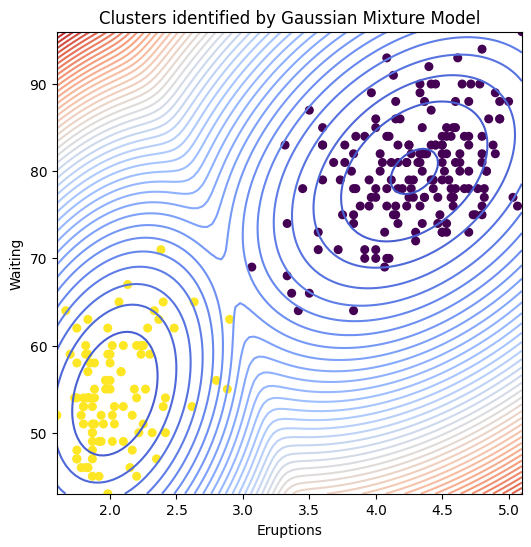

In [40]:
# Step 5: Visualize the clusters
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis')
ax.set_title("Clusters identified by Gaussian Mixture Model")
ax.set_xlabel("Eruptions")
ax.set_ylabel("Waiting")
# Plot the contour lines
plt.contour(Xx, Yy, Z, levels=50, cmap="coolwarm", zorder=1)
plt.show()

In [ ]:
# Initialize Parameters
def initialize_parameters(X, k):
    n_samples, n_features = X.shape
    # Randomly initialize the means
    means = X[np.random.choice(n_samples, k, False)]
    # Initialize covariances as identity matrices
    covariances = np.array([np.eye(n_features) for _ in range(k)])
    # Initialize weights (mixing coefficients) to be uniform
    weights = np.ones(k) / k
    return means, covariances, weights

In [70]:
n_samples, n_features = X.shape

In [43]:
np.random.choice(n_samples, 2, False)

array([ 34, 217])

In [45]:
X[np.random.choice(n_samples, 2, False)]

array([[ 1.817, 60.   ],
       [ 4.417, 90.   ]])

In [49]:
np.array([np.eye(2) for _ in range(2)])

(2, 2, 2)

In [71]:
k=2
weights = np.ones(k)/k

In [72]:
n_samples = X.shape[0]

In [60]:
responsibilities = np.zeros((n_samples, k))

In [61]:
responsibilities.shape

(272, 2)

In [73]:
means = X[np.random.choice(n_samples, k, False)]
# Initialize covariances as identity matrices
covariances = np.array([np.eye(n_features) for _ in range(k)])

In [74]:
means

array([[ 4.567, 78.   ],
       [ 2.367, 63.   ]])

In [75]:
for k in range(2):
    responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])

In [76]:
def initialize_parameters(X, n_components):
    n_features = X.shape[1]
    means = X[np.random.choice(X.shape[0], n_components, replace=False)]
    covariances = np.array([np.eye(n_features)] * n_components)
    mixing_coefficients = np.ones(n_components) / n_components
    return means, covariances, mixing_coefficients

In [77]:
def e_step(X, means, covariances, mixing_coefficients):
    n_samples = X.shape[0]
    n_components = len(mixing_coefficients)
    
    responsibilities = np.zeros((n_samples, n_components))
    
    for k in range(n_components):
        responsibilities[:, k] = mixing_coefficients[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    
    responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
    responsibilities /= responsibilities_sum
    
    return responsibilities


In [78]:
def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    
    means = np.zeros((n_components, n_features))
    covariances = np.zeros((n_components, n_features, n_features))
    mixing_coefficients = np.zeros(n_components)
    
    for k in range(n_components):
        resp_k = responsibilities[:, k]
        total_resp_k = resp_k.sum()
        means[k] = (X * resp_k[:, np.newaxis]).sum(axis=0) / total_resp_k
        X_centered = X - means[k]
        covariances[k] = np.dot(resp_k * X_centered.T, X_centered) / total_resp_k
        mixing_coefficients[k] = total_resp_k / n_samples
    
    return means, covariances, mixing_coefficients

In [79]:
def em_algorithm(X, n_components, n_iter=100, tol=1e-6):
    means, covariances, mixing_coefficients = initialize_parameters(X, n_components)
    log_likelihoods = []

    for i in range(n_iter):
        responsibilities = e_step(X, means, covariances, mixing_coefficients)
        means, covariances, mixing_coefficients = m_step(X, responsibilities)
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.dot(responsibilities, mixing_coefficients)))
        log_likelihoods.append(log_likelihood)
        
        if i > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            print(f"Convergence reached at iteration {i}")
            break

    return means, covariances, mixing_coefficients, log_likelihoods

In [146]:
# Fit the GMM
n_components = 2
means, covariances, mixing_coefficients, log_likelihoods = em_algorithm(X, n_components)

print("Means:\n", means)
print("Covariances:\n", covariances)
print("Mixing Coefficients:\n", mixing_coefficients)

Convergence reached at iteration 20
Means:
 [[ 2.03638846 54.4785164 ]
 [ 4.28966197 79.9681152 ]]
Covariances:
 [[[ 0.06916767  0.43516764]
  [ 0.43516764 33.69728219]]

 [[ 0.16996843  0.94060929]
  [ 0.94060929 36.04621098]]]
Mixing Coefficients:
 [0.35587286 0.64412714]


In [147]:
def gaussian_mixture_pdf(X, means, covariances, mixing_coefficients):
    """
    Compute the probability density function of a Gaussian Mixture Model.
    
    Parameters:
    - X: np.ndarray, shape (n_samples, n_features)
    - means: np.ndarray, shape (n_components, n_features)
    - covariances: list of np.ndarray, each of shape (n_features, n_features)
    - mixing_coefficients: np.ndarray, shape (n_components,)
    
    Returns:
    - densities: np.ndarray, shape (n_samples,)
    """
    densities = np.zeros(X.shape[0])
    for i in range(len(means)):
        densities += mixing_coefficients[i] * multivariate_normal.pdf(X, mean=means[i], cov=covariances[i])
    return densities

def plot_gmm_contours(X, means, covariances, mixing_coefficients):
    """
    Plot data points and the Gaussian Mixture Model contours.
    
    Parameters:
    - X: np.ndarray, shape (n_samples, 2) - Data points
    - means: np.ndarray, shape (n_components, 2) - Means of the Gaussians
    - covariances: list of np.ndarray - Covariances of the Gaussians
    - mixing_coefficients: np.ndarray - Mixing coefficients of the Gaussians
    """
    # Create a grid of points
    x = np.linspace(min(X[:, 0]), max(X[:, 0]), 200)
    y = np.linspace(min(X[:, 1]), max(X[:, 1]), 200)
    Xx, Yy = np.meshgrid(x, y)
    XY = np.column_stack([Xx.ravel(), Yy.ravel()])
    
    # Compute the density values for each point in the grid
    Z = gaussian_mixture_pdf(XY, means, covariances, mixing_coefficients)
    Z = Z.reshape(Xx.shape)
    Z = np.log1p(Z) 
    
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the data points
    ax.scatter(X[:, 0], X[:, 1], c='black', s=30, cmap='viridis', zorder=2)
    
    # Plot the contour lines
    contour = ax.contour(Xx, Yy, Z, levels=50, cmap="coolwarm", zorder=1)
    ax.clabel(contour, inline=True, fontsize=8)
    
    ax.set_title("Clusters identified by Gaussian Mixture Model")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    
    plt.show()

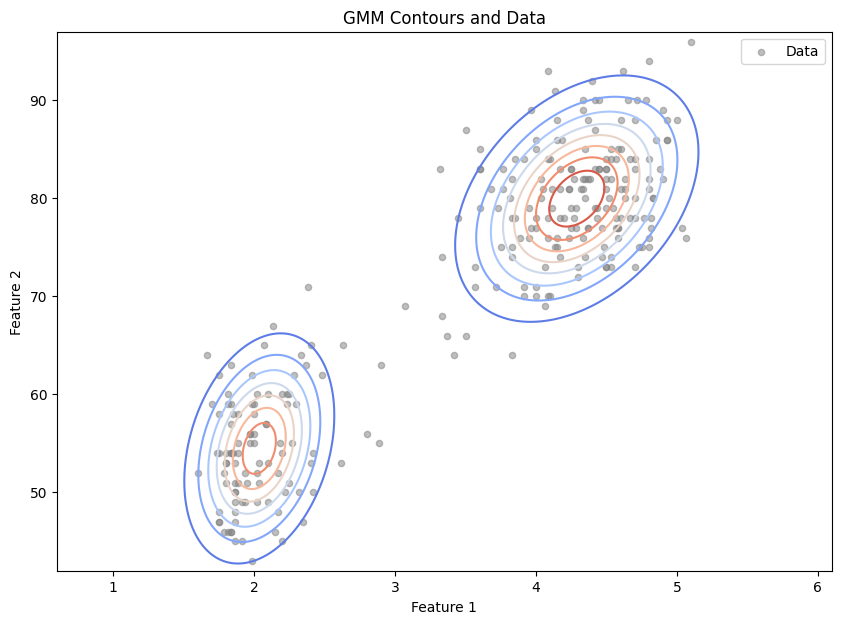

In [148]:
plot_gmm(X, means, covariances, mixing_coefficients)